# Matching CVs con Red Neuronal creada desde 0

## 1. Carga y Preparación de Datos

### Montaje de Google Drive

In [27]:
# ─── MONTAJE DE GOOGLE DRIVE ─────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Definición de rutas y mapping

In [28]:
# ─── IMPORTS ──────────────────────────────────────────────────────────────
import pandas as pd
import os
import numpy as np

# Ruta a la carpeta con los archivos CSV
BASE_PATH = "/content/drive/MyDrive/TFM/red_neuronal/interim"

In [29]:
MAPPING = {
    'cdatos':    'Ciencia_de_datos',
    'ingdatos':  'Ingeniero_de_datos',
    'jurista':   'Jurista',
    'traductor': 'Traductor_de_inglés'
}

MAX_TOKENS = 300

### Carga de CVs y ofertas

In [ ]:
def load_cvs(path, mapping):
    df = pd.read_csv(path)

    # Filtrar solo nombres que tengan uno de los códigos válidos
    mask = df['Nombre del archivo'].str.contains(r'_(cdatos|ingdatos|jurista|traductor)_')
    df_validos = df[mask].copy()
    df_invalidos = df[~mask]['Nombre del archivo'].tolist()

    if df_invalidos:
        print("Se excluyen estos nombres de archivo (no parecen CVs válidos):")
        print("\n".join(df_invalidos))

    # Ahora sí extraemos el código solo de los válidos
    df_validos['code'] = df_validos['Nombre del archivo'].str.extract(r'_(cdatos|ingdatos|jurista|traductor)_')[0]
    df_validos['category'] = df_validos['code'].map(mapping)

    # Si hay algo que no mapeó, lo advertimos
    unmapped = df_validos['category'].isna()
    if unmapped.any():
        bad = df_validos.loc[unmapped, 'Nombre del archivo'].tolist()
        raise ValueError("Estos CVs tienen un código válido pero no están en MAPPING:\n" +
                         "\n".join(bad))

    df_validos = df_validos.rename(columns={'Texto extraído': 'cv_text', 'Nombre del archivo': 'cv_id'})
    return df_validos[['cv_id', 'cv_text', 'category']]

def load_offers(offer_files):
    offers = []
    for cat, fp in offer_files.items():
        df = pd.read_csv(fp).rename(columns={'descripcion_oferta': 'offer_text'})
        df['offer_id'] = df.index.astype(str) + f'_{cat}'
        df['offer_category'] = cat
        offers.append(df[['offer_id', 'offer_text', 'offer_category']])
    return pd.concat(offers, ignore_index=True)

Se cargan los archivos CSV de currículums (CVs) y ofertas de empleo.

En el caso de los CVs:

- Se filtran solo los archivos cuyo nombre contiene un código de categoría válido

- Se verifica que todos los códigos extraídos tengan una correspondencia en el diccionario `MAPPING`.

- Se lanza un error si se detectan CVs con códigos válidos pero no definidos en el `MAPPING`.

En el caso de las ofertas, se construye un identificador único por oferta y se etiqueta cada una con su categoría correspondiente.

Esto garantiza que solo se trabajará con ejemplos consistentes y etiquetados correctamente.

In [30]:
# ─── CARGA DE DATOS ───────────────────────────────────────────────────────
# CVs de entrenamiento
cvs_path = os.path.join(BASE_PATH, "cvs_train_preprocesado.csv")
df_cvs = load_cvs(cvs_path, MAPPING)

# Ofertas por categoría
offer_files = {
    'Ciencia_de_datos': os.path.join(BASE_PATH, 'Ciencia_de_datos_España_ofertas.csv'),
    'Ingeniero_de_datos': os.path.join(BASE_PATH, 'Ingeniero_de_datos_España_ofertas.csv'),
    'Traductor_de_inglés': os.path.join(BASE_PATH, 'Traductor_de_inglés_Málaga_ofertas.csv'),
    'Jurista': os.path.join(BASE_PATH, 'Jurista_Málaga_ofertas.csv')
}

offers = load_offers(offer_files)


Se excluyen estos nombres de archivo (no parecen CVs válidos):
CV_numeropdf_oferta_numerooferta.pdf


<ipython-input-21-727503ea7a93>:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df['Nombre del archivo'].str.contains(r'_(cdatos|ingdatos|jurista|traductor)_')


### Creación de pares CV-oferta

In [ ]:
def make_pairs(df_cvs, df_offers):
    df_cvs = df_cvs.assign(key=1)
    df_offers = df_offers.assign(key=1)
    pairs = df_cvs.merge(df_offers, on='key').drop('key', axis=1)
    pairs['label'] = (pairs['category'] == pairs['offer_category']).astype(int)
    return pairs.rename(columns={'category':'cv_category'})

Se genera el conjunto de entrenamiento combinando todos los CVs con todas las ofertas mediante un producto cartesiano.

Cada par CV-oferta recibe una etiqueta binaria:
- `label = 1` si la categoría del CV coincide con la categoría de la oferta.
- `label = 0` en caso contrario.

Este etiquetado permite entrenar el modelo como una tarea de clasificación binaria, donde el objetivo es predecir si un par es un "match" (coincidente) o no.  
Se imprime además la distribución de clases para verificar el balance del dataset resultante.

In [31]:
pairs = make_pairs(df_cvs, offers)

### Verificación de la distribución

In [32]:
# ─── VERIFICACIÓN FINAL ──────────────────────────────────────────────────
print("CVs cargados:", len(df_cvs))
print("Ofertas cargadas:", len(offers))
print("Total de pares generados:", len(pairs))
print("Distribución de clases (label):")
print(pairs['label'].value_counts())


CVs cargados: 72
Ofertas cargadas: 19
Total de pares generados: 1368
Distribución de clases (label):
label
0    1024
1     344
Name: count, dtype: int64


## 2. División del Dataset y Preprocesamiento

### Split de entrenamiento y validación

Primero se divide el dataset en entrenamiento y validación, asegurando que no haya CVs duplicados entre ambos conjuntos.  
La división se hace a nivel de `cv_id`, manteniendo el 80% para entrenamiento y el 20% para validación.

Después, se realiza una limpieza básica del texto tanto en los CVs como en las ofertas:
- Se eliminan tildes y signos de puntuación.
- Se convierte todo a minúsculas.
- Se normalizan los espacios.

Esta limpieza estandariza el texto y reduce ruido para mejorar la calidad del entrenamiento posterior.

In [33]:
# ─── SPLIT DE ENTRENAMIENTO Y VALIDACIÓN ─────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, ndcg_score

# Dividimos el dataset de pares con labels (80% train, 20% valid)
unique_cvs = pairs['cv_id'].unique()
cv_train_ids, cv_val_ids = train_test_split(unique_cvs, test_size=0.2, random_state=42)

pairs_train = pairs[pairs['cv_id'].isin(cv_train_ids)].copy()
pairs_val = pairs[pairs['cv_id'].isin(cv_val_ids)].copy()

print(f"Pares para entrenamiento: {len(pairs_train)}")
print(f"Pares para validación: {len(pairs_val)}")
print("Distribución en train:")
print(pairs_train['label'].value_counts())
print("Distribución en validación:")
print(pairs_val['label'].value_counts())


Pares para entrenamiento: 1083
Pares para validación: 285
Distribución en train:
label
0    812
1    271
Name: count, dtype: int64
Distribución en validación:
label
0    212
1     73
Name: count, dtype: int64


### Limpieza de texto

In [ ]:
def limpiar_texto(texto):
    # Eliminar tildes y normalizar unicode
    texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Pasar a minúsculas
    texto = texto.lower()

    # Sustituir signos de puntuación por espacios
    texto = re.sub(r"[\.,;:!\?()\[\]\"']", " ", texto)

    # Sustituir múltiples espacios por uno
    texto = re.sub(r"\s+", " ", texto).strip()

    return texto

In [37]:
# ─── IMPORTACIONES ────────────────────────────────────────────────────────
import re
import unicodedata
from tqdm import tqdm

tqdm.pandas()


In [38]:
# ─── APLICAMOS LIMPIEZA AL DATASET DE PARES ──────────────────────────────
for campo in ['cv_text', 'offer_text']:
    print(f"Limpiando campo: {campo}")
    pairs_train[campo] = pairs_train[campo].progress_apply(limpiar_texto)
    pairs_val[campo] = pairs_val[campo].progress_apply(limpiar_texto)


Limpiando campo: cv_text


100%|██████████| 285/285 [00:00<00:00, 4430.26it/s]


Limpiando campo: offer_text


100%|██████████| 285/285 [00:00<00:00, 4320.35it/s]


### Truncado y augmentación

In [ ]:
def truncar_texto(texto, max_tokens=MAX_TOKENS):
    tokens = texto.split()
    if len(tokens) > max_tokens:
        return " ".join(tokens[:max_tokens])
    else:
        return texto

def permutar_frases(texto):
    import random, re
    frases = [f.strip() for f in re.split(r"[\.!?]", texto) if f.strip()]
    if len(frases) <= 1:
        return texto  # no permutamos si no hay más de una frase
    random.shuffle(frases)
    return ". ".join(frases) + "."

def augment_train(pairs):
    pos = pairs[pairs.label==1].copy()
    pos['cv_text'] = pos['cv_text'].apply(permutar_frases)
    pos['offer_text'] = pos['offer_text'].apply(permutar_frases)
    pos['cv_id']    = pos['cv_id'] + "_aug"
    pos['offer_id'] = pos['offer_id'] + "_aug"
    return pd.concat([pairs, pos], ignore_index=True)

Primero se aplican dos transformaciones clave sobre los textos:

1. **Truncado de texto**: se limitan los CVs y ofertas a un máximo de `MAX_TOKENS` palabras. Esto evita entradas excesivamente largas que podrían desbordar la memoria durante el entrenamiento.

2. **Aumento de datos (data augmentation)**: se duplican los pares positivos (`label = 1`) generando una nueva versión donde se permutan aleatoriamente las frases del CV y de la oferta.  
   Esto introduce variabilidad en el orden del contenido sin alterar su significado, lo que ayuda a mejorar la robustez del modelo.

Los nuevos ejemplos se identifican con sufijos `_aug` en sus `cv_id` y `offer_id`.

In [39]:
# ─── TRUNCADO DE TEXTOS LARGOS ─────────────────────────────────

for campo in ['cv_text', 'offer_text']:
    pairs_train[campo] = pairs_train[campo].apply(truncar_texto)
    pairs_val[campo] = pairs_val[campo].apply(truncar_texto)


In [40]:
# ─── AUGMENT TRAIN ─────────────────────────────────────────────────────────
pairs_train = augment_train(pairs_train)

print(f"Nuevo tamaño de pairs_train tras augmentación: {len(pairs_train)}")
print("Distribución tras augmentación:")
print(pairs_train['label'].value_counts())


Nuevo tamaño de pairs_train tras augmentación: 1354
Distribución tras augmentación:
label
0    812
1    542
Name: count, dtype: int64


### Guardado de pares limpios

In [41]:
# ─── GUARDAR COPIAS PREPROCESADAS ──────────────────────────────
pairs_train.to_csv(os.path.join(BASE_PATH, "pairs_train_clean.csv"), index=False)
pairs_val.to_csv(os.path.join(BASE_PATH, "pairs_val_clean.csv"), index=False)


### Tokenización

In [ ]:
from collections import Counter
def construir_vocab(textos, vocab_size=8000, min_freq=2):
    c = Counter()
    for t in textos: c.update(t.split())
    vocab = {'<PAD>':0,'<UNK>':1}
    idx = 2
    for tok,f in c.most_common():
        if f < min_freq or len(vocab)>=vocab_size: break
        vocab[tok] = idx; idx+=1
    return vocab

def text_to_indices(texto, vocab, max_len=300):
    tokens = texto.split()[:max_len]
    ids = [vocab.get(tok, vocab['<UNK>']) for tok in tokens]
    ids += [vocab['<PAD>']] * (max_len-len(ids))
    return ids

def tokenize_pairs(pairs, vocab):
    df = pairs.copy()
    df['cv_input_ids']    = df['cv_text'].apply(lambda t: text_to_indices(t, vocab))
    df['offer_input_ids'] = df['offer_text'].apply(lambda t: text_to_indices(t, vocab))
    return df

Se construye el vocabulario del modelo a partir de todos los textos de CVs y ofertas (entrenamiento y validación), limitando el tamaño máximo del vocabulario y filtrando por frecuencia mínima.

Con ese vocabulario, se tokenizan los textos:
- Cada palabra se convierte en su índice correspondiente.
- Se aplica padding o truncado para que todos los ejemplos tengan la misma longitud.

El resultado es un dataset preparado para alimentar directamente a una red neuronal.

In [42]:
# ─── 1. CONSTRUIR EL VOCABULARIO SOBRE TODOS LOS TEXTOS ─────────────────────
# Concatenamos todos los textos de CVs y ofertas (train y val)
todos_los_textos = pd.concat([
    pairs_train['cv_text'],
    pairs_train['offer_text'],
    pairs_val['cv_text'],
    pairs_val['offer_text']
])

# Construimos vocabulario
vocab = construir_vocab(todos_los_textos, vocab_size=8000, min_freq=2)

print(f"Vocabulario creado con {len(vocab)} tokens.")


Vocabulario creado con 2631 tokens.


In [ ]:
pairs_train_tokenized = tokenize_pairs(pairs_train, vocab)
pairs_val_tokenized = tokenize_pairs(pairs_val, vocab)

print(f"Pairs train tokenized shape: {pairs_train_tokenized.shape}")
print(f"Pairs val tokenized shape: {pairs_val_tokenized.shape}")


Pairs train tokenized shape: (1354, 9)
Pairs val tokenized shape: (285, 9)


✅ La tokenización se ha aplicado correctamente: cada par CV–oferta tiene ahora sus representaciones en índices (`cv_input_ids` y `offer_input_ids`), listas para ser usadas en el modelo.

Ambos datasets (`train` y `val`) contienen 9 columnas, lo que indica que conservan los campos originales más los tokens generados.


## 3. Arquitectura del Modelo

### Definición del encoder CNN-LSTM

**SiameseEncoderCNNLSTM**:  
   Este encoder transforma una secuencia de tokens en una representación vectorial.  
   Su estructura combina:
   - Una capa de embeddings.
   - Una convolución 1D para extraer patrones locales.
   - Una LSTM bidireccional que captura dependencias a largo plazo.
   - Un max-pooling global para obtener una representación fija del texto.

In [ ]:
class SiameseEncoderCNNLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, conv_out=64, lstm_hidden=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.conv = nn.Conv1d(in_channels=emb_dim,
                              out_channels=conv_out,
                              kernel_size=5,
                              padding=2)
        self.lstm = nn.LSTM(input_size=conv_out,
                            hidden_size=lstm_hidden,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, L)
        x = self.embedding(x)               # (B, L, E)
        x = x.transpose(1,2)                # (B, E, L)
        c = F.relu(self.conv(x))            # (B, C, L)
        c = c.transpose(1,2)                # (B, L, C)
        o, _ = self.lstm(c)                 # (B, L, 2*H)
        o_max, _ = o.max(dim=1)             # (B, 2*H)
        return self.dropout(o_max)

### Modelo Siamese con MLP final

**SiameseSimilarityModelEnhanced**:  
   Recibe dos secuencias (CV y oferta), genera sus representaciones con el encoder, las concatena y las pasa por un pequeño MLP que aprende una función de similitud.  
   La salida final es un valor ∈ [0,1] interpretado como score de adecuación.

In [ ]:
class SiameseSimilarityModelEnhanced(nn.Module):
    def __init__(self, vocab_size, encoder_cls, encoder_kwargs, seq_len=300):
        super().__init__()
        self.encoder = encoder_cls(vocab_size, **encoder_kwargs)
        # Medimos D_enc usando un tensor de prueba
        with torch.no_grad():
            dummy = torch.zeros(1, seq_len, dtype=torch.long)
            D_enc = self.encoder(dummy).shape[1]

        # Ahora construimos el MLP con las dimensiones correctas
        self.mlp = nn.Sequential(
            nn.Linear(2 * D_enc, D_enc),
            nn.ReLU(),
            nn.Dropout(encoder_kwargs.get('dropout', 0.3)),
            nn.Linear(D_enc, 1),
            nn.Sigmoid()
        )

    def forward(self, a, b):
      va = self.encoder(a)                    # (B, D_enc)
      vb = self.encoder(b)                    # (B, D_enc)
      x  = torch.cat([va, vb], dim=1)         # (B, 2*D_enc)
      return self.mlp(x).squeeze(1)           # (B,)

### Hiperparámetros y construcción del modelo

Se definen los hiperparámetros clave del encoder: dimensión de embeddings, tamaño de los filtros convolucionales, dimensión oculta del LSTM y tasa de dropout.

A continuación, se instancia el modelo `SiameseSimilarityModelEnhanced`, indicando la clase de encoder y los parámetros definidos.  
El modelo se mueve a GPU si está disponible (`"cuda"`).

In [50]:
VOCAB_SIZE = len(vocab)  # el vocabulario que creaste en Fase 1

# Definición del encoder “mejorado”
encoder_kwargs = {
    'emb_dim':      128,
    'conv_out':     64,
    'lstm_hidden':  128,
    'dropout':      0.3
}

# Creas el modelo pasándole la clase del encoder y sus argumentos
model = SiameseSimilarityModelEnhanced(
    vocab_size   = VOCAB_SIZE,
    encoder_cls  = SiameseEncoderCNNLSTM,
    encoder_kwargs = encoder_kwargs
).to("cuda")



### Pérdida y optimizador

También se establece:
- La **función de pérdida** como entropía binaria (`BCELoss`), apropiada para una salida ∈ [0,1].
- El **optimizador** como `AdamW`, que incorpora regularización mediante decaimiento del peso (`weight_decay`), útil para evitar overfitting.

In [59]:
# Creamos la función de pérdida
from torch import nn

loss_fn = nn.BCELoss()


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)


## 4. Entrenamiento del Modelo

### Dataset y DataLoaders

In [ ]:
from torch.utils.data import Dataset, DataLoader
class PairsDataset(Dataset):
    def __init__(self, df):
        self.cv_ids    = df['cv_input_ids'].tolist()
        self.offer_ids = df['offer_input_ids'].tolist()
        self.labels    = df['label'].tolist()
    def __len__(self): return len(self.labels)
    def __getitem__(self,i):
        return {
            'cv_input_ids':    torch.tensor(self.cv_ids[i], dtype=torch.long),
            'offer_input_ids': torch.tensor(self.offer_ids[i], dtype=torch.long),
            'label':           torch.tensor(self.labels[i], dtype=torch.float)
        }

Primero se define una clase `PairsDataset` que convierte el DataFrame tokenizado en un dataset compatible con PyTorch.  
Luego se crean los `DataLoader` para entrenamiento y validación.

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_dataset = PairsDataset(pairs_train_tokenized)
val_dataset = PairsDataset(pairs_val_tokenized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


### Funciones de entrenamiento y evaluación

In [ ]:
# Importamos todas las métricas necesarias
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

def evaluate_classification(y_true, y_pred_proba, threshold=0.5):
    """
    Evalúa las métricas básicas de clasificación dado un umbral sobre el score.
    """
    y_pred = (y_pred_proba >= threshold).astype(int)

    print(f"Evaluación con umbral = {threshold}")
    print("- Accuracy:", accuracy_score(y_true, y_pred))
    print("- F1 Score:", f1_score(y_true, y_pred))
    print("- Precision:", precision_score(y_true, y_pred))
    print("- Recall:", recall_score(y_true, y_pred))
    print("- AUC:", roc_auc_score(y_true, y_pred_proba))
    print("- Clasification report:")
    print(classification_report(y_true, y_pred))

def train_model(model,
                pairs_train_df,
                pairs_val_df,
                device='cuda',
                epochs=50,
                patience=4,
                show_every=10,
                threshold=0.7,
                save_path="/content/drive/MyDrive/TFM/red_neuronal/modelo_mejor.pt"):
    """
    Entrena el modelo siamés con early stopping y logging controlado.

    Args:
      model: instancia de SiameseSimilarityModel ya movida a `device`.
      pairs_train_df: DataFrame tokenizado para entrenamiento.
      pairs_val_df:   DataFrame tokenizado para validación.
      device: 'cuda' o 'cpu'.
      epochs: número máximo de épocas.
      patience: épocas sin mejora para parar.
      show_every: cada cuántas épocas imprimir métricas.
      threshold: umbral para clasificación de y_pred en f1_score.
      save_path: ruta donde guardar el mejor modelo.
    """
    # 1) Prepara DataLoaders
    class PairsDataset(Dataset):
        def __init__(self, df):
            self.cv_ids    = df['cv_input_ids'].tolist()
            self.offer_ids = df['offer_input_ids'].tolist()
            self.labels    = df['label'].tolist()
        def __len__(self): return len(self.labels)
        def __getitem__(self, i):
            return {
                'cv_input_ids':    torch.tensor(self.cv_ids[i], dtype=torch.long),
                'offer_input_ids': torch.tensor(self.offer_ids[i], dtype=torch.long),
                'label':           torch.tensor(self.labels[i], dtype=torch.float)
            }

    train_loader = DataLoader(PairsDataset(pairs_train_df), batch_size=32, shuffle=True)
    val_loader   = DataLoader(PairsDataset(pairs_val_df),   batch_size=64)

    # 2) Pérdida y optimizador
    loss_fn   = torch.nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

    best_f1 = 0.0
    epochs_without_improvement = 0

    for epoch in range(1, epochs+1):
        # --- Entrenamiento de una época ---
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            cv_in  = batch['cv_input_ids'].to(device)
            ofr_in = batch['offer_input_ids'].to(device)
            lbl    = batch['label'].to(device)

            optimizer.zero_grad()
            preds = model(cv_in, ofr_in)
            loss  = loss_fn(preds, lbl)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)

        # --- Evaluación en validación ---
        model.eval()
        all_y, all_p = [], []
        with torch.no_grad():
            for batch in val_loader:
                cv_in  = batch['cv_input_ids'].to(device)
                ofr_in = batch['offer_input_ids'].to(device)
                lbl    = batch['label'].to(device)
                preds  = model(cv_in, ofr_in)
                all_y.extend(lbl.cpu().numpy())
                all_p.extend(preds.cpu().numpy())

        # Convertimos a numpy arrays para poder hacer comparacion con threshold
        all_y = np.array(all_y)
        all_p = np.array(all_p)

        # Cálculo de F1
        f1 = f1_score(all_y, (np.array(all_p) >= threshold).astype(int))

        # Early stopping & guardado del mejor modelo
        if f1 > best_f1:
            best_f1 = f1
            epochs_without_improvement = 0
            torch.save(model.state_dict(), save_path)
        else:
            epochs_without_improvement += 1

        # Logging controlado
        if epoch % show_every == 0 or epoch == epochs:
            print(f"\n🔁 Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | F1: {f1:.4f}")
            evaluate_classification(all_y, all_p, threshold=threshold)

        # Comprueba early stopping
        if epochs_without_improvement >= patience:
            print(f"\n⏹️ Early stopping en epoch {epoch} (sin mejora en {patience} epochs).")
            break

    print(f"\n🏁 Entrenamiento finalizado. Mejor F1 obtenida: {best_f1:.4f}")
    # Carga el mejor modelo guardado
    model.load_state_dict(torch.load(save_path))
    return model

La función `train_model` encapsula todo el proceso de entrenamiento:

- Usa `BCELoss` como función de pérdida y `AdamW` como optimizador.
- Entrena durante un número máximo de épocas (`epochs`), pero detiene anticipadamente si el F1 no mejora tras `patience` épocas.
- Evalúa tras cada época usando métricas clásicas (F1, precisión, recall, AUC).
- Guarda el modelo con mejor F1 en el archivo indicado (`save_path`).
- Devuelve el modelo ya cargado con los pesos óptimos.

Este diseño permite entrenar y validar el modelo de forma controlada y reproducible, incluyendo logs periódicos e interrupción automática si no hay progreso.

### Ejecución del entrenamiento

Se lanza el entrenamiento del modelo utilizando la función `train_model`.

- Se detecta automáticamente si hay GPU disponible (`"cuda"`).
- Se especifican hiperparámetros clave como:
  - `epochs`: número máximo de épocas de entrenamiento.
  - `patience`: número de épocas sin mejora tras las cuales se activa el early stopping.
  - `threshold`: umbral para considerar un score como positivo en las métricas.
  - `show_every`: frecuencia con la que se imprime el estado de entrenamiento.
  - `save_path`: ruta donde se guarda el mejor modelo encontrado.

El modelo devuelto ya contiene los pesos entrenados óptimos según el F1 en validación.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Entrenamos
model = train_model(
    model,
    pairs_train_df = pairs_train_tokenized,
    pairs_val_df   = pairs_val_tokenized,
    device         = device,
    epochs         = 5,
    patience       = 2,
    show_every     = 2,
    threshold      = 0.25,
    save_path      = "/content/drive/MyDrive/TFM/red_neuronal/modelo_mejor.pt"
)



🔁 Epoch 5/25 | Train Loss: 0.6623 | F1: 0.4257
Evaluación con umbral = 0.25
- Accuracy: 0.3087719298245614
- F1 Score: 0.42565597667638483
- Precision: 0.27037037037037037
- Recall: 1.0
- AUC: 0.6389894029464978
- Clasification report:
              precision    recall  f1-score   support

         0.0       1.00      0.07      0.13       212
         1.0       0.27      1.00      0.43        73

    accuracy                           0.31       285
   macro avg       0.64      0.54      0.28       285
weighted avg       0.81      0.31      0.21       285


🔁 Epoch 10/25 | Train Loss: 0.0069 | F1: 0.7682
Evaluación con umbral = 0.25
- Accuracy: 0.8771929824561403
- F1 Score: 0.7682119205298014
- Precision: 0.7435897435897436
- Recall: 0.7945205479452054
- AUC: 0.9254975445851641
- Clasification report:
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       212
         1.0       0.74      0.79      0.77        73

    accuracy         

Durante el entrenamiento se observa una evolución clara de las métricas:

- En la **época 5**, el modelo aún no distingue correctamente entre clases. La F1 es baja, el accuracy es inferior al 31%, y aunque el recall es 1.0, la precisión es muy baja (el modelo predice muchos falsos positivos).
- En la **época 10**, el modelo mejora significativamente. La F1 sube a 0.77, con buena precisión y recall balanceados. El AUC también es alto (0.93), lo que indica que el modelo discrimina bien entre clases.

El entrenamiento se detuvo automáticamente en la época 13 mediante **early stopping**, al no detectarse mejora durante 5 épocas consecutivas.  
El mejor modelo se guardó con un **F1 óptimo de 0.7975**.

Estos resultados sugieren que el modelo ha aprendido una representación efectiva y es capaz de generalizar razonablemente bien sobre los datos de validación.

## 5. Evaluación y Calibración

### Evaluación del modelo entrenado y Calibración con Platt Scaling

In [60]:
def evaluate(model, loader, device='cuda'):
    """
    Ejecuta evaluación del modelo sobre un DataLoader.
    Devuelve:
      - y_true: etiquetas reales (array)
      - y_pred: scores ∈ [0,1] del modelo (array)
    """
    model.eval()
    all_y = []
    all_p = []

    with torch.no_grad():
        for batch in loader:
            cv_input  = batch['cv_input_ids'].to(device)
            ofr_input = batch['offer_input_ids'].to(device)
            labels    = batch['label'].to(device)

            preds = model(cv_input, ofr_input)  # salida ∈ [0,1]
            all_y.extend(labels.cpu().numpy())
            all_p.extend(preds.cpu().numpy())

    return np.array(all_y), np.array(all_p)


Se define la función `evaluate` para obtener las predicciones del modelo sobre un `DataLoader`, devolviendo tanto las etiquetas reales (`y_true`) como los scores crudos (`y_pred`) en el rango [0,1].

A continuación, se aplica **Platt Scaling**, un método clásico de calibración de probabilidades. Consiste en ajustar una regresión logística sobre los scores del modelo para que las salidas se interpreten como probabilidades calibradas.

Se entrena este calibrador sobre las predicciones del conjunto de validación. El parámetro `C` controla la regularización: un valor más bajo produce una curva de calibración más suave.  
El calibrador entrenado se guarda en disco para su uso posterior en la inferencia sobre datos de test.

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

def calibrate_platt(y_true, y_raw, save_path, C=0.1, max_iter=1000):
    """
    Entrena un calibrador Platt (LogisticRegression) con regularización fuerte.

    Args:
      y_true:  array de etiquetas {0,1}.
      y_raw:   array de scores bruto ∈ [0,1].
      save_path: ruta donde guardar el calibrador.
      C:        inverso de fuerza de regularización (C pequeño → más regularización).
      max_iter: iteraciones máximas para converger.
    """
    # 1) Aseguramos que trabajamos con numpy arrays
    X = np.array(y_raw).reshape(-1,1)
    y = np.array(y_true)

    # 2) Creamos y entrenamos el calibrador con C pequeño
    lr = LogisticRegression(solver='lbfgs', C=C, max_iter=max_iter)
    lr.fit(X, y)

    # 3) Guardamos el calibrador
    joblib.dump(lr, save_path)
    return lr

In [ ]:
# Eval final
y_true, y_pred = evaluate(model, val_loader)

# Calibrar el modelo con Platt Scaling
platt = calibrate_platt(y_true, y_pred, save_path="/content/drive/MyDrive/TFM/red_neuronal/platt_scaling.joblib", C=10)


### Histogramas de calibración

In [ ]:
def rank_offers_for_cv_calibrated(cv_input_ids, offer_input_ids, model, platt, top_n=5):
    model.eval()
    with torch.no_grad():
        cv_input_ids = cv_input_ids.to("cuda")
        offer_input_ids = offer_input_ids.to("cuda")
        if cv_input_ids.shape[0] == 1:
            cv_input_ids = cv_input_ids.expand(offer_input_ids.size(0), -1)

        # 2.2 Obtén score bruto ∈ [0,1]
        raw_scores = model(cv_input_ids, offer_input_ids).cpu().numpy()
        # 2.3 Calibra con Platt Scaling
        prob_scores = platt.predict_proba(raw_scores.reshape(-1, 1))[:, 1]
        # 2.4 Pasa a porcentaje
        pct_scores = prob_scores * 100

    # 2.5 Ranking top-n
    top_idxs = pct_scores.argsort()[::-1][:top_n]
    return top_idxs, pct_scores

Se define una función `rank_offers_for_cv_calibrated` que toma un CV y un conjunto de ofertas, calcula los scores crudos con el modelo y los calibra usando el modelo de Platt Scaling previamente entrenado.

Los scores calibrados (probabilidades) se transforman a porcentajes para facilitar su interpretación.

Después:
- Se selecciona un CV específico del conjunto de validación.
- Se convierte su texto en índices.
- Se tokenizan todas las ofertas de validación.
- Se ejecuta la función de ranking para obtener las ofertas más adecuadas ordenadas por su score calibrado.

Se imprime el top-N de ofertas más relevantes para ese CV, mostrando tanto el score como un extracto del texto de la oferta.

In [ ]:
# Seleccionar un CV por ID
cv_id_objetivo = pairs_val_tokenized['cv_id'].iloc[0]
cv_texto = pairs_val_tokenized[pairs_val_tokenized['cv_id'] == cv_id_objetivo]['cv_text'].iloc[0]


In [ ]:
# Convertimos el texto a indices con tu vocab y padding
cv_indices = text_to_indices(cv_texto, vocab, max_len=300)
cv_tensor = torch.tensor([cv_indices], dtype=torch.long)  # (1, seq_len)


In [ ]:
# Suponemos que tienes este DataFrame con ofertas de validación
df_ofertas = pairs_val_tokenized[['offer_id', 'offer_text']].drop_duplicates()

# Tokenizar todas las ofertas a índices
offer_tensors = [text_to_indices(text, vocab, max_len=300) for text in df_ofertas['offer_text']]
offers_tensor = torch.tensor(offer_tensors, dtype=torch.long)  # (N, seq_len)


In [ ]:
top_idxs, pct_scores = rank_offers_for_cv_calibrated(cv_tensor, offers_tensor, model, platt)

for i in top_idxs:
    texto = df_ofertas.iloc[i]['offer_text']
    print(f"{pct_scores[i]:.2f}% → {texto[:120]}...")


76.12% → acerca del empleo role splunk software engineer type of contract permanent working model hybrid 2 days in client office ...
74.72% → acerca del empleo te entusiasta el analisis de datos y quieres ser parte de un proyecto que vuela alto en innovacion for...
72.54% → acerca del empleo los ingenieros de software junior son profesionales tecnicamente capacitados con el deseo de disenar d...
72.54% → acerca del empleo los ingenieros de software junior son profesionales tecnicamente capacitados con el deseo de disenar d...
71.96% → acerca del empleo hola somos lis data solutions una ingenieria especializada en el analisis de datos que acompana y ayud...


In [ ]:
df_val = pairs_val_tokenized.copy()
with torch.no_grad():
    scores = model(
        torch.tensor(list(df_val['cv_input_ids'])).to("cuda"),
        torch.tensor(list(df_val['offer_input_ids'])).to("cuda")
    ).detach().cpu().numpy() * 100

df_val['score'] = scores
df_val.sort_values(by='score', ascending=False).to_csv("/content/val_resultados_score.csv", index=False)


Se realiza una inferencia completa sobre el conjunto de validación, calculando los scores de adecuación entre cada par CV–oferta.  
Los resultados se guardan en un archivo CSV ordenado por score descendente (`val_resultados_score.csv`), útil para análisis o inspección manual.

A continuación, se aplica el calibrador Platt a los scores del modelo (`y_pred`) para visualizar la distribución de probabilidades calibradas.  
El histograma permite observar si el modelo produce una separación clara entre clases y si la calibración suaviza o comprime los scores en rangos razonables de probabilidad.

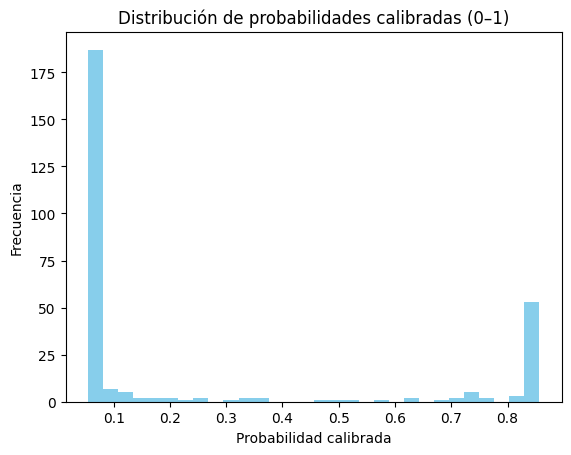

In [ ]:
import matplotlib.pyplot as plt
# Aplica calibración a tus y_pred crudos
prob_scores = platt.predict_proba(y_pred.reshape(-1,1))[:,1]

plt.hist(prob_scores, bins=30, color='skyblue')
plt.title("Distribución de probabilidades calibradas (0–1)")
plt.xlabel("Probabilidad calibrada")
plt.ylabel("Frecuencia")
plt.show()

La gráfica muestra la distribución de scores calibrados (probabilidades ∈ [0,1]) obtenidos tras aplicar Platt Scaling a los resultados del modelo.

Se observan dos acumulaciones claras:
- Una gran mayoría de pares tienen probabilidades muy bajas (cerca de 0.05–0.1), lo que indica que el modelo está seguro de que **no son un match**.
- Un segundo grupo más pequeño, pero bien definido, se concentra en la zona alta (>0.8), indicando predicciones **positivas con alta confianza**.

La escasez de valores en la zona intermedia sugiere que el modelo tiende a ser bastante decisivo, lo cual puede ser positivo para tareas de ranking si se prioriza precisión en el top-N.  
Esta distribución también indica que la calibración ha suavizado adecuadamente los scores crudos sin colapsarlos a 0 o 1.

## 6. Inferencia en CVs de Test

### Carga y limpieza de los CVs de test

In [ ]:
# Importamos librerías
import unicodedata
import re

# ─── CARGA Y PREPROCESADO DE LOS CV DE TEST ────────────────────────────────
test_path = os.path.join(BASE_PATH, "cvs_test_preprocesado.csv")
df_test = pd.read_csv(test_path).rename(columns={'Texto extraído': 'cv_text', 'Nombre del archivo': 'cv_id'})

# Limpieza y truncado
df_test['cv_text'] = df_test['cv_text'].apply(limpiar_texto).apply(truncar_texto)

Se realiza el preprocesado completo para aplicar el modelo a nuevos CVs sin etiqueta:

1. **Carga de test**: se lee el archivo `cvs_test_preprocesado.csv`, renombrando las columnas relevantes.

### Combinación CV-oferta y Tokenización

In [ ]:
# ─── TOKENIZAMOS LOS CVS ───────────────────────────────────────────────────
df_test['cv_input_ids'] = df_test['cv_text'].apply(lambda x: text_to_indices(x, vocab, max_len=300))

# ─── PREPARAMOS EL DATASET DE OFERTAS ──────────────────────────────────────
df_ofertas = offers.copy()  # Las ofertas ya estaban cargadas en tu flujo
df_ofertas = df_ofertas.rename(columns={'offer_text': 'offer_text', 'offer_id': 'offer_id'})
df_ofertas['offer_text'] = df_ofertas['offer_text'].apply(limpiar_texto).apply(truncar_texto)
df_ofertas['offer_input_ids'] = df_ofertas['offer_text'].apply(lambda x: text_to_indices(x, vocab, max_len=300))

2. **Limpieza y truncado**: se aplica la misma limpieza y limitación de longitud usada en entrenamiento, garantizando consistencia.

3. **Tokenización**: los textos de los CVs y las ofertas se convierten a secuencias de índices utilizando el vocabulario previamente construido.

4. **Producto cartesiano**: se generan todos los pares posibles `CV_test × Oferta`, creando el conjunto sobre el que se hará inferencia.

In [ ]:
# ─── PRODUCTO CARTESIANO ENTRE TEST Y OFERTAS ──────────────────────────────
df_test = df_test.assign(key=1)
df_ofertas = df_ofertas.assign(key=1)
pairs_test = df_test.merge(df_ofertas, on='key').drop('key', axis=1)

### Tensores

5. **Conversión a tensores**: las secuencias tokenizadas se convierten a tensores PyTorch para poder pasarlas al modelo en batch.

Este bloque deja los datos completamente preparados para ejecutar el modelo y obtener los scores de adecuación.

In [ ]:
# ─── CONVERSIÓN A TENSORES ─────────────────────────────────────────────────
cv_tensor     = torch.tensor(list(pairs_test['cv_input_ids']), dtype=torch.long)
offer_tensor  = torch.tensor(list(pairs_test['offer_input_ids']), dtype=torch.long)

### Predicción de scores calibrados

In [52]:
import torch

# Inicializamos el modelo
model = SiameseSimilarityModelEnhanced(
    vocab_size   = VOCAB_SIZE,
    encoder_cls  = SiameseEncoderCNNLSTM,
    encoder_kwargs = encoder_kwargs
).to("cuda")

# Load the saved model
model.load_state_dict(torch.load("/content/drive/MyDrive/TFM/red_neuronal/modelo_mejor.pt"))
model.eval()

# Load the Platt scaling calibrator
platt = joblib.load("/content/drive/MyDrive/TFM/red_neuronal/platt_scaling.joblib")


Se carga el modelo entrenado (`modelo_mejor.pt`) y el calibrador de Platt (`platt_scaling.joblib`) para realizar inferencia sobre los pares `CV_test × Oferta`.

- Se ejecuta el modelo en modo evaluación (`eval`) sin computar gradientes.
- Los scores crudos del modelo (∈ [0,1]) se calibran con Platt Scaling para obtener probabilidades más fiables.
- Se construye un DataFrame con los resultados, incluyendo el identificador del CV, el de la oferta, el texto de la oferta y el score calibrado.

In [54]:
# ─── CÁLCULO DE SCORES CALIBRADOS ──────────────────────────────────────────
model.eval()
with torch.no_grad():
    cv_tensor = cv_tensor.to("cuda")
    offer_tensor = offer_tensor.to("cuda")

    # Si no están del mismo tamaño, expande los CV (pero aquí ya están pareados)
    raw_scores = model(cv_tensor, offer_tensor).cpu().numpy()
    prob_scores = platt.predict_proba(raw_scores.reshape(-1,1))[:,1]

In [55]:
# ─── CONSTRUCCIÓN DEL DATAFRAME FINAL ──────────────────────────────────────
df_resultados = pairs_test[['cv_id', 'offer_id', 'offer_text']].copy()
df_resultados['score'] = prob_scores

### Exportación de resultados

Finalmente, se exporta el ranking completo a un archivo CSV (`rankings_test_generado.csv`) que puede usarse para análisis o recomendaciones posteriores.

In [56]:
# ─── EXPORTACIÓN A CSV ─────────────────────────────────────────────────────
output_path = "/content/drive/MyDrive/TFM/red_neuronal/rankings_test_generado.csv"
df_resultados.to_csv(output_path, index=False)

print("✅ CSV generado con éxito:", output_path)

✅ CSV generado con éxito: /content/drive/MyDrive/TFM/red_neuronal/rankings_test_generado.csv
